In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from datetime import timedelta
from xgboost import XGBClassifier
import os
from scipy.stats import entropy
from scipy.stats import uniform, randint

import sys
init_dir = os.getcwd()

In [3]:
consumer_df = pd.read_parquet(init_dir + '/cashflow-data/consumer_data.parquet')
transactions = pd.read_parquet(init_dir + '/cashflow-data/transactions.parquet')

In [4]:
consumer_df['evaluation_date'] = pd.to_datetime(consumer_df['evaluation_date'])
transactions['posted_date'] = pd.to_datetime(transactions['posted_date'])

In [5]:
# Step 1: Filter transactions to only those before or on the evaluation date
transactions_df = transactions.merge(
    consumer_df[['masked_consumer_id', 'evaluation_date']],
    on='masked_consumer_id',
    how='left'
)
transactions_df = transactions_df[transactions_df['posted_date'] < transactions_df['evaluation_date']]

In [6]:
# Step 2: Feature Engineering
# Create debit/credit indicators
transactions_df['is_credit'] = transactions_df['amount'] > 0
transactions_df['is_debit'] = transactions_df['amount'] < 0

# Compute aggregate features
agg = transactions_df.groupby('masked_consumer_id').agg(
    total_amount=('amount', 'sum'),
    mean_amount=('amount', 'mean'),
    std_amount=('amount', 'std'),
    min_amount=('amount', 'min'),
    max_amount=('amount', 'max'),
    median_amount=('amount', 'median'),
    transaction_count=('amount', 'count'),
    credit_sum=('is_credit', lambda x: transactions_df.loc[x.index, 'amount'][x].sum()),
    debit_sum=('is_debit', lambda x: abs(transactions_df.loc[x.index, 'amount'][x].sum()))
)

# Ratio of credits to debits
agg['credit_debit_ratio'] = agg['credit_sum'] / agg['debit_sum'].replace(0, np.nan)
agg['credit_debit_ratio'] = agg['credit_debit_ratio'].fillna(0)

# Recent 30-day transaction features
transactions_df['days_before_eval'] = (transactions_df['evaluation_date'] - transactions_df['posted_date']).dt.days
recent_df = transactions_df[transactions_df['days_before_eval'] <= 30].groupby('masked_consumer_id').agg(
    recent30_sum=('amount', 'sum'),
    recent30_count=('amount', 'count')
)

# Monthly cashflow volatility: std / mean
transactions_df['month'] = transactions_df['posted_date'].dt.to_period('M')
monthly_cashflow = transactions_df.groupby(['masked_consumer_id', 'month'])['amount'].sum().reset_index()
monthly_stats = monthly_cashflow.groupby('masked_consumer_id')['amount'].agg(['mean', 'std']).rename(
    columns={'mean': 'monthly_mean', 'std': 'monthly_std'}
)
monthly_stats['monthly_cv'] = monthly_stats['monthly_std'] / monthly_stats['monthly_mean'].replace(0, np.nan)
monthly_stats = monthly_stats.fillna(0)

# category
cat_encode = pd.get_dummies(transactions_df, columns = ['category'], drop_first = False)
cat_encode.rename(columns = {f"category_{i}.0": f"category_{i}_mean" for i in range(36)}, inplace = True)
cat_encode_mean = cat_encode.groupby('masked_consumer_id').agg({f"category_{i}_mean": 'sum' for i in range(36)})


# weekend vs weekday transactions
transactions_df['weekday'] = transactions_df['posted_date'].dt.weekday
transactions_df['is_weekend'] = transactions_df['weekday'] >= 5

weekend_spend = transactions_df[transactions_df['amount'] > 0].groupby(['masked_consumer_id', 'is_weekend'])['amount'].sum().unstack(fill_value=0)
weekend_spend.columns = ['weekday_spending', 'weekend_spending']
weekend_spend['weekend_ratio'] = weekend_spend['weekend_spending'] / (weekend_spend['weekday_spending'] + 1e-6)

# Transaction frequency and span
txn_freq = transactions_df.groupby('masked_consumer_id').agg(
    unique_txn_days=('posted_date', lambda x: x.nunique()),
    txn_days_span=('posted_date', lambda x: (x.max() - x.min()).days + 1),
)
txn_freq['txn_per_day'] = txn_freq['unique_txn_days'] / txn_freq['txn_days_span'].replace(0, 1)

# percentiles of transaction amounts
percentiles = transactions_df.groupby('masked_consumer_id')['amount'].quantile([0.25, 0.75, 0.9]).unstack()
percentiles.columns = ['amount_25pct', 'amount_75pct', 'amount_90pct']

# number of large transactions
threshold = 1000  
transactions_df['is_large'] = transactions_df['amount'].abs() > threshold
large_txns = transactions_df.groupby('masked_consumer_id')['is_large'].sum().rename('large_txn_count')

# general trendline of monthly transactions
monthly_spend = transactions_df.groupby(['masked_consumer_id', 'month'])['amount'].sum().reset_index()
monthly_spend['month'] = monthly_spend['month'].dt.to_timestamp()  

def compute_monthly_trend(df):
    if df.shape[0] < 2:
        return 0 
    df = df.sort_values('month')
    x = (df['month'] - df['month'].min()).dt.days.values.reshape(-1, 1)
    y = df['amount'].values
    model = LinearRegression().fit(x, y)
    return model.coef_[0] 
monthly_trend = monthly_spend.groupby('masked_consumer_id').apply(compute_monthly_trend).rename('monthly_spend_trend')

# Merge all features
features_df = consumer_df.set_index('masked_consumer_id') \
    .join(agg, how='left') \
    .join(recent_df, how='left') \
    .join(monthly_stats, how='left') \
    .join(cat_encode_mean, how='left') \
    .join(txn_freq, how='left') \
    .join(weekend_spend, how='left') \
    .join(large_txns, how='left') \
    .join(monthly_trend, how='left') \
    .fillna(0)

C:\Users\manat\AppData\Local\Temp\ipykernel_2280\2566243800.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_trend = monthly_spend.groupby('masked_consumer_id').apply(compute_monthly_trend).rename('monthly_spend_trend')


In [7]:

# # Step 3: Train-Test Split
# X = features_df.drop(columns=['FPF_TARGET', 'evaluation_date'])
# y = features_df['FPF_TARGET']
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=2/9, random_state=42)

# # Define pipeline
# pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('model', XGBClassifier(use_label_encoder=False, random_state=42))
# ])

# # Hyperparameter grid
# param_distributions = {
#     'model__n_estimators': randint(100, 500),
#     'model__learning_rate': uniform(0.01, 0.2),
#     'model__max_depth': randint(3, 10),
# }

# # Randomized search
# search = RandomizedSearchCV(
#     pipeline,
#     param_distributions=param_distributions,
#     n_iter=50,
#     scoring='roc_auc',
#     n_jobs=-1,
#     cv=3,
#     random_state=42,
#     verbose=1
# )

# # Fit model
# search.fit(X_train, y_train)

# # Best model and evaluation
# best_model = search.best_estimator_
# y_train_pred = best_model.predict_proba(X_train)[:, 1]
# y_val_pred = best_model.predict_proba(X_val)[:, 1]
# train_auc = roc_auc_score(y_train, y_train_pred)
# val_auc = roc_auc_score(y_val, y_val_pred )
# y_test_pred = best_model.predict_proba(X_test)[:, 1]
# test_auc = roc_auc_score(y_test, y_test_pred)

# print(f"Best Parameters: {search.best_params_}")
# print(f"Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
# print(f"Test AUC: {test_auc:.4f}")

In [8]:
from sklearn.metrics import classification_report
# Step 3: Train-Test Split

X = features_df.drop(columns=['FPF_TARGET', 'evaluation_date'])
y = features_df['FPF_TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)
# Step 4: Pipeline with Imputation and Logistic Regression
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('model', XGBClassifier(n_estimators=400, learning_rate=0.05, random_state=42,  max_depth = 3))
])

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict_proba(X_train)[:, 1]
y_val_pred = pipeline.predict_proba(X_val)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred) 
val_auc = roc_auc_score(y_val, y_val_pred)
print(f"Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")


Train AUC: 0.9436, Validation AUC: 0.8931


In [17]:
X.columns

Index(['total_balance', 'total_amount', 'mean_amount', 'std_amount',
       'min_amount', 'max_amount', 'median_amount', 'transaction_count',
       'credit_sum', 'debit_sum', 'credit_debit_ratio', 'recent30_sum',
       'recent30_count', 'monthly_mean', 'monthly_std', 'monthly_cv',
       'category_0_mean', 'category_1_mean', 'category_2_mean',
       'category_3_mean', 'category_4_mean', 'category_5_mean',
       'category_6_mean', 'category_7_mean', 'category_8_mean',
       'category_9_mean', 'category_10_mean', 'category_11_mean',
       'category_12_mean', 'category_13_mean', 'category_14_mean',
       'category_15_mean', 'category_16_mean', 'category_17_mean',
       'category_18_mean', 'category_19_mean', 'category_20_mean',
       'category_21_mean', 'category_22_mean', 'category_23_mean',
       'category_24_mean', 'category_25_mean', 'category_26_mean',
       'category_27_mean', 'category_28_mean', 'category_29_mean',
       'category_30_mean', 'category_31_mean', 'category

In [9]:
import xgboost as xgb
models = xgb.Booster({'nthread': 4})  # init model
models.load_model('baseline_model.json')

In [16]:
x_preds = models.predict(xgb.DMatrix(X_val))
roc_auc_score(y_val, x_preds)

0.8930843439829319

In [10]:
pipeline['model'].save_model('baseline_model.json')

<Axes: >

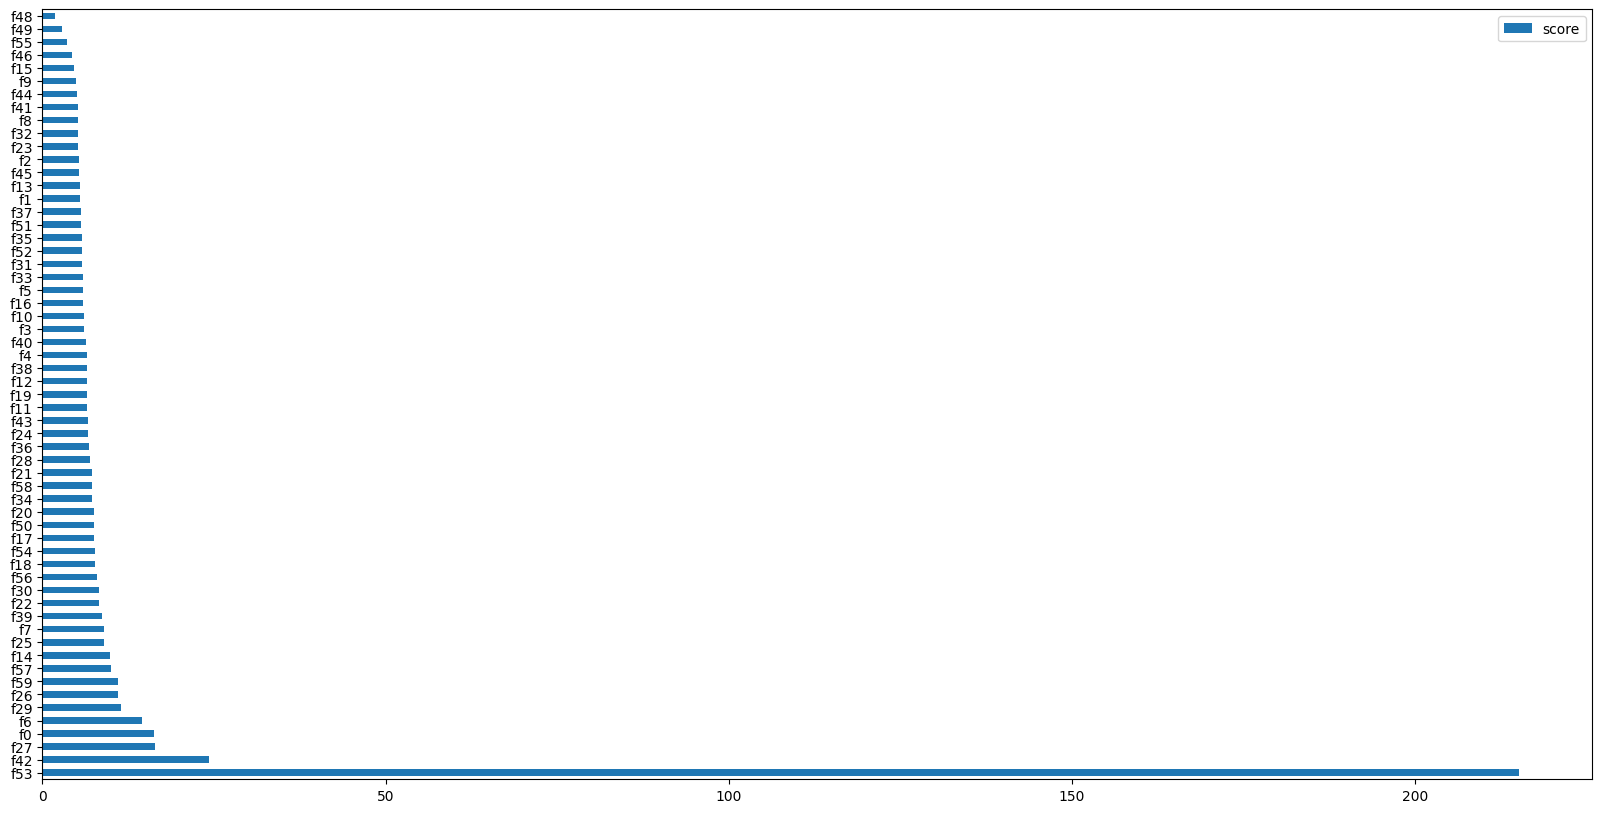

In [11]:
feature_important = pipeline['model'].get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(60, columns="score").plot(kind='barh', figsize = (20,10)) 

In [12]:
for x in data.index:
    print(X_train.columns[int(x[1:])]) 

txn_days_span
category_26_mean
category_11_mean
total_balance
median_amount
category_13_mean
category_10_mean
monthly_spend_trend
weekend_ratio
monthly_std
category_9_mean
transaction_count
category_23_mean
category_6_mean
category_14_mean
weekend_spending
category_2_mean
txn_per_day
category_1_mean
category_34_mean
category_4_mean
category_18_mean
large_txn_count
category_5_mean
category_12_mean
category_20_mean
category_8_mean
category_27_mean
recent30_sum
category_3_mean
recent30_count
category_22_mean
min_amount
category_24_mean
std_amount
credit_debit_ratio
category_0_mean
max_amount
category_17_mean
category_15_mean
unique_txn_days
category_19_mean
category_35_mean
category_21_mean
total_amount
monthly_mean
category_29_mean
mean_amount
category_7_mean
category_16_mean
credit_sum
category_25_mean
category_28_mean
debit_sum
monthly_cv
category_30_mean
weekday_spending
category_33_mean
category_32_mean


In [13]:
categories_val = []
for x in [1,2,3,4]:
    cur_features = features_df[features_df.index.str[2] == str(x)].drop(columns=['FPF_TARGET', 'evaluation_date'])
    y_val_pred = pipeline.predict_proba(X_val[X_val.index.str[2] == str(x)])[:, 1]
    categories_val.append(roc_auc_score(y_val[y_val.index.str[2] == str(x)], y_val_pred))
    print(f'Val AUC for category {x}: {categories_val[-1]:.4f}')

Val AUC for category 1: 0.8389
Val AUC for category 2: 0.6757
Val AUC for category 3: 0.6905
Val AUC for category 4: 0.6476


In [14]:
features_df['category_5_mean']

masked_consumer_id
C01100001     9.0
C01100002    13.0
C01100003     0.0
C01100004     0.0
C01100005     0.0
             ... 
C04104996    21.0
C04104997     0.0
C04104998     0.0
C04104999     0.0
C04105000     0.0
Name: category_5_mean, Length: 16000, dtype: float64